# Benchmarking

Here are some scripts for benchmarking the framework, which only includes dataset loading if dataset have been pre generated - or with dataset creation time if not. The timing also includes inference and mapping to the physically-constrained embeding space. 

Note that the time to identify motifs in atomistic data that is spent during dataset creation time could be further reduced if needed. Also note that this dataset creation time is minimal when applied to the synthetic dataset as we only need to permute the atomic type of a reference graph.

Additonally the framework currently relies on pandas dataframe, we may convert it to use polars dataframe instead for speed improvements. 


In [13]:
%%capture
! pip install lovelyplots 
! pip install git+https://github.com/ovito-org/GenerateRandomSolution.git
! pip install ase 

import time

import matplotlib.pyplot as plt
from _frameworks import MonteCarloChemicalMotifIdentifier
import lovelyplots 
plt.style.use(["paper"])
%matplotlib inline


import os

import GenerateRandomSolution as grs
import numpy as np
from ase.build import bulk
from ovito.io import export_file
from ovito.io.ase import ase_to_ovito
from ovito.pipeline import Pipeline, StaticSource

In [14]:
def generate_random_system(crystal_structure: str, size: tuple):
    os.makedirs("data/benchmark/dumps/", exist_ok=True)

    # Create a full Cu system
    atoms = bulk(name="Cu", crystalstructure=crystal_structure, a=1, cubic=True).repeat(
        size
    )

    data = ase_to_ovito(atoms)
    pipeline = Pipeline(source=StaticSource(data=data))

    # Apply the RSS modifier based on the above wanted concentration
    pipeline.modifiers.append(
        grs.GenerateRandomSolution(
            only_selected=False,
            concentrations=[1 / 3, 1 / 3, 1 / 3],
            seed=np.random.randint(1000000),
        )
    )

    data = pipeline.compute()

    export_file(
        data,
        f"data/benchmark/dumps/{crystal_structure}_{size}.dump",
        "lammps/dump",
        columns=[
            "Particle Identifier",
            "Particle Type",
            "Position.X",
            "Position.Y",
            "Position.Z",
        ],
    )

In [15]:
structure = "fcc"
nrange = np.arange(5, 30, 5)

for n in nrange:
    generate_random_system(structure, size=(n, n, n))

dump_files = [f"data/benchmark/dumps/fcc_{(n,n,n)}.dump" for n in nrange]
times = []

eca = MonteCarloChemicalMotifIdentifier(crystal_structure=structure)
for i, dump_file in enumerate(dump_files):
    print(f'Timing a system with {4*nrange[i]**3} atoms...')
    t = time.perf_counter()
    root = f"data/benchmark/motif_id/dump_{i}/"
    df = eca.predict(root=root, dump_file=dump_file)
    final_time = time.perf_counter() - t
    times.append(final_time)
    print(f'It took {final_time}s. \n ')

/opt/homebrew/lib/python3.11/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


Timing a system with 500 atoms...


Inference:   0%|          | 0/2 [00:00<?, ?it/s]

/var/folders/14/8lklrynj04jgznbn0p84mzy80000gn/T/ipykernel_98574/368125022.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


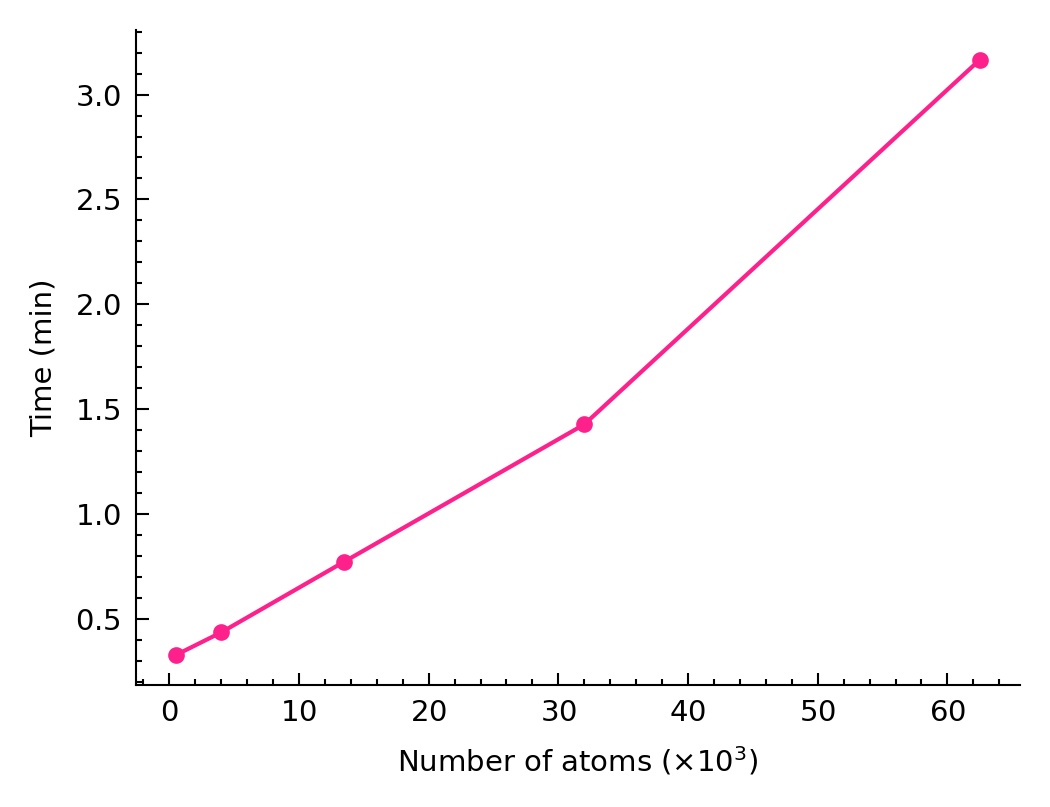

In [ ]:
fig, ax = plt.subplots()
ax.plot(nrange**3 * 4 / 1000, np.array(times)/60, "-o")
ax.set_ylabel(r"Time (min)")
ax.set_xlabel(r"Number of atoms ($\times 10^3$)")
fig.savefig("number_of_atoms_vs_time.pdf")
fig.show()